In [1]:
from ARB_Volume_Equations import *
from ARB_Equation_Assignments_PLANTS import VolumeEq_Dict_PLANTS as PLANTS
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set_style('darkgrid')

In [3]:
fname = 'C:\GitHub\FSC_Case_Studies\defect_adjustments\Merchantable_Western_Trees.xlsx'
tree_list = pd.read_excel(fname)

In [4]:
# let's only consider trees 15+" DBH, and drop any trees with missing values
tree_list = tree_list.loc[tree_list.dbh >= 15].dropna()

In [5]:
tree_list.head()

,FIA_spp_code,PLANTS_symbol,common_name,tree_cn,dbh,ht,NVEL_Scribner
0,11,ABAM,Pacific silver fir,15139215010497,16.6,66,243
1,11,ABAM,Pacific silver fir,15166034010497,21.6,109,612
2,11,ABAM,Pacific silver fir,15166039010497,18.6,100,454
3,11,ABAM,Pacific silver fir,15166818010497,30.2,125,1580
4,11,ABAM,Pacific silver fir,15166819010497,20.0,104,527


In [6]:
# calculate boardfoot volume for each tree
def get_BF(row):
    if PLANTS[row.PLANTS_symbol]['type'] == 'HW': # calculate scribner volume for hardwoods
        try:
            return PLANTS[row.PLANTS_symbol]['WOR']().calc(DBH=row.dbh, HT=row.ht, metric='SV816')
        except TypeError: # some species have an assigned equation in western Oregon
            return PLANTS[row.PLANTS_symbol]['WWA']().calc(DBH=row.dbh, HT=row.ht, metric='SV816')
    elif PLANTS[row.PLANTS_symbol]['type'] == 'SW': # calculate scribner volume for softwoods
        try:
            return PLANTS[row.PLANTS_symbol]['WOR']().calc(DBH=row.dbh, HT=row.ht, metric='SV632')
        except TypeError:
            return PLANTS[row.PLANTS_symbol]['WWA']().calc(DBH=row.dbh, HT=row.ht, metric='SV632')

In [7]:
tree_list['FIA_Scribner'] = tree_list.apply(get_BF, axis = 1) # calculate scribner volume for each row

In [8]:
def calc_defect(row):
    if row.NVEL_Scribner == 0:
        return np.nan
    else:
        return (row.NVEL_Scribner - row.FIA_Scribner)/row.NVEL_Scribner

In [9]:
tree_list['defect_adjust'] = tree_list.apply(calc_defect, axis=1)

In [10]:
def calc_DBHclass(row):
    cls = row.dbh//5 * 5 # bin into 5" DBH classes
    return min(cls,25) # everything over 25" DBH lumped into one class

In [11]:
tree_list['dbh_cls'] = tree_list.apply(calc_DBHclass, axis=1)

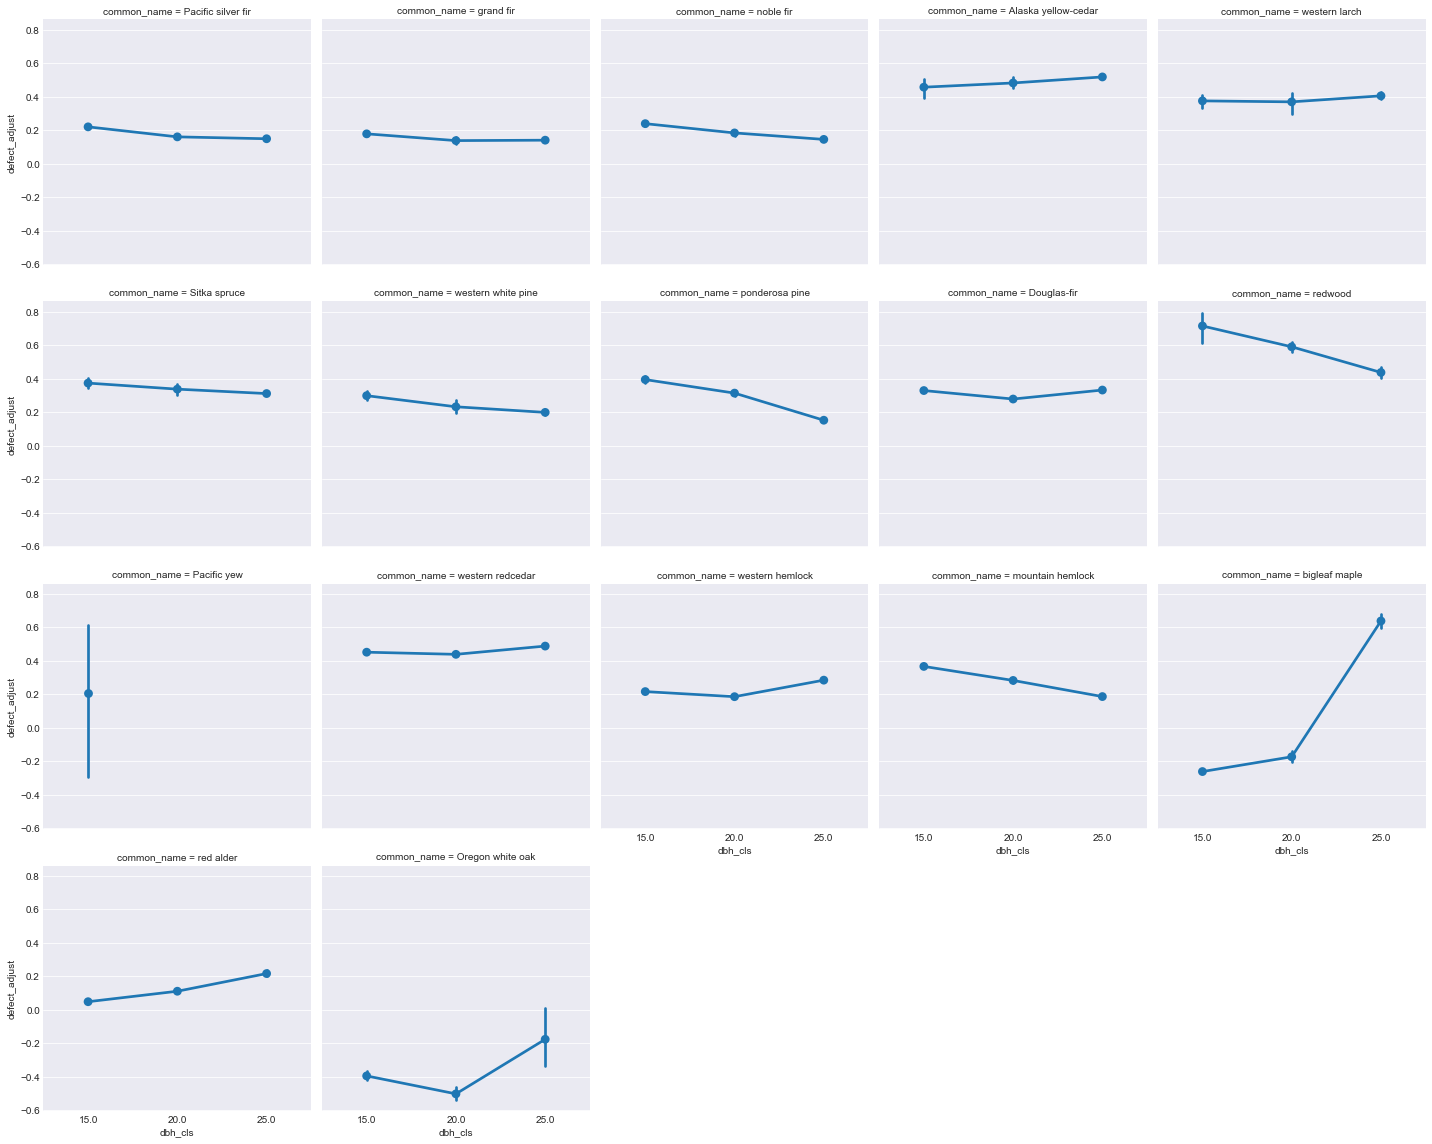

In [12]:
g = sns.factorplot(data=tree_list, x='dbh_cls', y='defect_adjust', col='common_name', col_wrap=5)

In [13]:
pd.pivot_table(tree_list, values='defect_adjust', 
               index='common_name', columns='dbh_cls', aggfunc='mean').style.format("{:.2f}")

dbh_cls,15.0,20.0,25.0
common_name,,,
Alaska yellow-cedar,0.46,0.48,0.52
Douglas-fir,0.33,0.28,0.33
Oregon white oak,-0.40,-0.50,-0.18
Pacific silver fir,0.22,0.16,0.15
Pacific yew,0.21,nan,nan
Sitka spruce,0.37,0.34,0.31
bigleaf maple,-0.26,-0.17,0.64
grand fir,0.18,0.14,0.14
mountain hemlock,0.37,0.28,0.19


In [14]:
pd.pivot_table(tree_list, values='defect_adjust', 
               index='common_name', columns='dbh_cls', aggfunc='count').style.format("{:,.0f}")

dbh_cls,15.0,20.0,25.0
common_name,,,
Alaska yellow-cedar,93,45,203
Douglas-fir,"10,838","5,443","31,043"
Oregon white oak,65,22,25
Pacific silver fir,"1,778",861,"2,900"
Pacific yew,8,0,nan
Sitka spruce,182,107,600
bigleaf maple,460,148,286
grand fir,271,131,255
mountain hemlock,780,471,"1,141"
